# Step 4 - Pre-Processing and Training Data

## 4.1 Preliminary work in the EDA

In previous Notebooks we performed preliminary assessments of data quality and answered two questions in relation with the data:

**1) Is there any way that we can cluster the universe of heroes?:**

We **clustered heroes** according to median values for certain end game metrics, such as number of kills, deaths, and assists performed by each hero, the amount of gold earned in the game, etc. As a result we defined 3 categories for heroes:

* Hero function - setting a total of 6 different hero functions (i.e. Killer, Squishy, etc.)
* Hero Farm - setting a total of 3 different farm dependency levels (i.e. Low Farm, Moderate Farm and High Farm)
* Hero Powerspike - setting a total of 3 different powerspikes (i.e. Early Game, Mid Game and Late Game)

**2) Is there any variable/s that are good indicators of the winning chances of a team?:**

We **determined** that an advantage in gold per minute (gpm) and experience per minute (xpm) was critical in success chances, and **winning teams**, regardless of the game duration, **had generally an advantage of gpm and xpm.**

## 4.2 Scope

In this step we will focus on preparing the data to be input to the supervised learning model:

In a **first model** we will work only with information available at the beginning of the match, this is, heroes selected and their categories, based on the clusters generated in the EDA step.

In a **second model**, we will include gpm and xpm data at minutes 5, 8, 10, 12 and 15 for each team. This will probably increase the model's accuracy, as we observed that these variables are great indicators on the winning chances. To avoid data leakage, we will limit the information to minute 15 of the game.

*Note that gpm and xpm data is not available at the beginning of each match. If we include too many minutes, our predictions will be very good but due to data leakage. To be conservative, we will limit beforehand the data provided to minute 15. As games on average last around 45 minutes, including gpm and xpm information for each team until minute 15 of each game is not very aggressive in terms of data leakage.*

**Summary:**

In this Notebook, we will build 2 supervised machine learning models, and compare their performance against the mean value as predictor. Having as baseline the mean, we will be able to develop and assess improvements in the subsequent models we will build.


## 4.3 Imports

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression, f_classif
from sklearn import metrics
import datetime

## 4.4 Load Data

We read the 2 files created in the previous step EDA:

In [2]:
#csv file containing minute by minute gpm and xpm information per game
Time_Data = pd.read_csv(r'C:\Users\34658\SPRINGBOARD\Dota 2 - Capstone Project\3.EDA\Time Data.csv')
#csv file containing categories of heroes by match
Categories_Data = pd.read_csv(r'C:\Users\34658\SPRINGBOARD\Dota 2 - Capstone Project\3.EDA\Categories Data.csv')

In [3]:
#we check the head of time data dataframe
Time_Data.head(4)

,Unnamed: 0,match_id,min,gold_radiant,gold_dire,gpm_radiant,gpm_dire,xp_radiant,xp_dire,xpm_radiant,xpm_dire,diff_gpm,diff_xpm,radiant_win
0,0,0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,True
1,1,0,1.0,222.6,274.0,222.600000,274.000000,138.4,138.4,138.400000,138.4,-51.4,0.000000,True
2,2,0,2.0,494.2,545.2,247.100000,272.600000,475.2,463.6,237.600000,231.8,-25.5,5.800000,True
3,3,0,3.0,698.0,811.4,232.666667,270.466667,726.8,708.6,242.266667,236.2,-37.8,6.066667,True


In [4]:
#we check the head of categories dataframe
Categories_Data.head(4)

,Unnamed: 0,index,match_id,player_slot,localized_name,hero_function,hero_powerspike,hero_farm,radiant_win,team,winner
0,0,0,0,0,Rubick,Support killer / Squishy,Early game,Low Farm,True,radiant,1
1,1,8183,0,1,Clockwerk,Core Killer / Pusher / Squishy,Early game,Low Farm,True,radiant,1
2,2,12484,0,2,Treant Protector,Support healer / Tank,Early game,Low Farm,True,radiant,1
3,3,14226,0,3,Shadow Fiend,Core Killer / Pusher/ Tank,Late game,High Farm,True,radiant,1


### 4.4.1 Preprocessing of data

The dataframes are not ready to be used in a machine learning model, in particular, there are several rows of information per match and we need them in one row per match.

#### 4.4.1.1 Model 1 - Categories Data (heroes selected + count of categories)

In [5]:
#we drop the column Unnamed: 0
Time_Data = Time_Data.drop(['Unnamed: 0'], axis=1)
#we set the match_id as index
Time_Data.set_index('match_id', inplace=True)
#create td variable for quicker access later on
td = Time_Data
td.head(2)

,min,gold_radiant,gold_dire,gpm_radiant,gpm_dire,xp_radiant,xp_dire,xpm_radiant,xpm_dire,diff_gpm,diff_xpm,radiant_win
match_id,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
0,1.0,222.6,274.0,222.6,274.0,138.4,138.4,138.4,138.4,-51.4,0.0,True


In [6]:
#check the shape, 12 columns and 2.2 million rows.
td.shape

(22096541, 12)

In [7]:
#drop column Unnamed: 0 and set index to match_id
Categories_Data = Categories_Data.drop(['Unnamed: 0','index'], axis=1)
Categories_Data = Categories_Data.set_index('match_id')
#we create variable cd for quicker access later on and check the head
cd = Categories_Data
cd.head(2)

,player_slot,localized_name,hero_function,hero_powerspike,hero_farm,radiant_win,team,winner
match_id,,,,,,,,
0,0,Rubick,Support killer / Squishy,Early game,Low Farm,True,radiant,1
0,1,Clockwerk,Core Killer / Pusher / Squishy,Early game,Low Farm,True,radiant,1


In [8]:
#we check the data types to convert them to categories.
cd.dtypes

player_slot         int64
localized_name     object
hero_function      object
hero_powerspike    object
hero_farm          object
radiant_win          bool
team               object
winner              int64
dtype: object

In [9]:
#we convert the columns that are objects into categories
for col in ['localized_name', 'hero_function', 'hero_powerspike', 'hero_farm']:
    cd[col] = cd[col].astype('category')

In [10]:
cd.dtypes

player_slot           int64
localized_name     category
hero_function      category
hero_powerspike    category
hero_farm          category
radiant_win            bool
team                 object
winner                int64
dtype: object

In [11]:
#we convert the object to dataframe and check the head
cd = pd.DataFrame(cd)
cd.head(4)

,player_slot,localized_name,hero_function,hero_powerspike,hero_farm,radiant_win,team,winner
match_id,,,,,,,,
0,0,Rubick,Support killer / Squishy,Early game,Low Farm,True,radiant,1
0,1,Clockwerk,Core Killer / Pusher / Squishy,Early game,Low Farm,True,radiant,1
0,2,Treant Protector,Support healer / Tank,Early game,Low Farm,True,radiant,1
0,3,Shadow Fiend,Core Killer / Pusher/ Tank,Late game,High Farm,True,radiant,1


What we want is to have a final categories dataframe that includes all the information per team in one row per game. To do this, we need to have several radiant columns and several dire columns. In particular:

* 1 radiant column per possible hero (111 columns), with 1 if it was selected and 0 if it was not selected;
* 1 radiant column per hero function (6 columns), with an integer from 0 to 5, meaning how many heroes of that function were selected in radiant team;
* 1 radiant column per farm dependency (3 columns), with an integer from 0 to 5, meaning how many heroes of that farm dependency were selected in radiant team; and
* 1 radiant column per hero powerspike (3 columns), with an integer from 0 to 5, meaning how many heroes of that powerspike were selected in radiant team.

The same nº of columns will be included for dire team, following this same logic above.

In order to obtain that dataframe, we will create separately team radiant and team dire columns and join them at the end side by side, based on the match_id.

In [12]:
#we split the dataset into radiant and dire teams
cd_rad = cd[cd['team']=='radiant']
cd_dire = cd[cd['team']=='dire']

In [13]:
cd_rad.columns

Index(['player_slot', 'localized_name', 'hero_function', 'hero_powerspike',
       'hero_farm', 'radiant_win', 'team', 'winner'],
      dtype='object')

In [14]:
#we first rename the columns of each dataframe to include the "rad_" and "dir_" prefix to join them later on
cd_rad = cd_rad.rename(columns={"player_slot": "rad_slot", "localized_name": "rad_hero", "hero_function": "rad_hfu", "hero_powerspike": "rad_hps", "hero_farm": "rad_hfa"})
cd_dire = cd_dire.rename(columns={"player_slot": "dir_slot", "localized_name": "dir_hero", "hero_function": "dir_hfu", "hero_powerspike": "dir_hps", "hero_farm": "dir_hfa"})

In [15]:
cd_rad.head(3)

,rad_slot,rad_hero,rad_hfu,rad_hps,rad_hfa,radiant_win,team,winner
match_id,,,,,,,,
0,0,Rubick,Support killer / Squishy,Early game,Low Farm,True,radiant,1
0,1,Clockwerk,Core Killer / Pusher / Squishy,Early game,Low Farm,True,radiant,1
0,2,Treant Protector,Support healer / Tank,Early game,Low Farm,True,radiant,1


In [16]:
#we create the dummies (binary) columns on each column for radiant team
cd_rad_hero = pd.get_dummies(cd_rad['rad_hero'])
cd_rad_fu = pd.get_dummies(cd_rad['rad_hfu'])
cd_rad_ps = pd.get_dummies(cd_rad['rad_hps'])
cd_rad_fa = pd.get_dummies(cd_rad['rad_hfa'])

In [17]:
#we create the dummies (binary) columns on each column for dire team
cd_dire_hero = pd.get_dummies(cd_dire['dir_hero'])
cd_dire_fu = pd.get_dummies(cd_dire['dir_hfu'])
cd_dire_ps = pd.get_dummies(cd_dire['dir_hps'])
cd_dire_fa = pd.get_dummies(cd_dire['dir_hfa'])

In [18]:
#We add up by match, for radiant team, each column.
cd_rad_hero1 = cd_rad_hero.groupby('match_id').sum()
#This will show the nº of heroes with each function
cd_rad_fu1 = cd_rad_fu.groupby('match_id').sum()
#This will show the nº of heroes with each powerspike
cd_rad_ps1 = cd_rad_ps.groupby('match_id').sum()
#This will show the nº of heroes with each farm dependency
cd_rad_fa1 = cd_rad_fa.groupby('match_id').sum()

#We add up by match, for dire team, each column.
cd_dire_hero1 = cd_dire_hero.groupby('match_id').sum()
#This will show the nº of heroes with each function
cd_dire_fu1 = cd_dire_fu.groupby('match_id').sum()
#This will show the nº of heroes with each powerspike
cd_dire_ps1 = cd_dire_ps.groupby('match_id').sum()
#This will show the nº of heroes with each farm dependency
cd_dire_fa1 = cd_dire_fa.groupby('match_id').sum()

In [19]:
#we add radiant prefix to column names
cd_rad_hero1.columns = ['radiant_' + str(col)  for col in cd_rad_hero1.columns]
cd_rad_fu1.columns = ['radiant_' + str(col) for col in cd_rad_fu1.columns]
cd_rad_ps1.columns = ['radiant_' + str(col) for col in cd_rad_ps1.columns]
cd_rad_fa1.columns = ['radiant_' + str(col) for col in cd_rad_fa1.columns]

#we add dire prefix to column names
cd_dire_hero1.columns = ['dire_' + str(col) for col in cd_dire_hero1.columns]
cd_dire_fu1.columns = ['dire_' + str(col) for col in cd_dire_fu1.columns]
cd_dire_ps1.columns = ['dire_' + str(col) for col in cd_dire_ps1.columns]
cd_dire_fa1.columns = ['dire_' + str(col) for col in cd_dire_fa1.columns]

As a final step, we join each dummies dataframe side by side, so that we will have a total of one row per match_id, as we initially wanted. This will allow us to input the data into the machine learning model.

In [20]:
#we concatenate all the dummies dataframes for radiant and dire teams
cd_ml = pd.concat([cd_rad_hero1,cd_dire_hero1,cd_rad_fu1,cd_dire_fu1,cd_rad_ps1,cd_dire_ps1,cd_rad_fa1,cd_dire_fa1],axis=1)
#we check the head to ensure it is in the format that we need
cd_ml.head(3)

,radiant_Abaddon,radiant_Alchemist,radiant_Ancient Apparition,radiant_Anti-Mage,radiant_Axe,radiant_Bane,radiant_Batrider,radiant_Beastmaster,radiant_Bloodseeker,radiant_Bounty Hunter,...,radiant_Mid game,dire_Early game,dire_Late game,dire_Mid game,radiant_High Farm,radiant_Low Farm,radiant_Moderate Farm,dire_High Farm,dire_Low Farm,dire_Moderate Farm
match_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,1,2,2,2,3,0,2,1,2
1,0,0,0,0,0,0,0,0,0,0,...,2,1,2,2,1,2,2,2,1,2
2,0,0,0,0,0,0,0,0,0,0,...,2,3,0,2,1,2,2,0,3,2


Lately, we add the information about the target variable, this is, what team won each match. We have this information from the previous cd dataframe.

In [21]:
#we will bring the radiant_win column data to this dataframe
winner = cd[['radiant_win']]

In [22]:
#we reset the index
winner.reset_index(inplace=True)
#we drop any duplicate values that we may have
winner = winner.drop_duplicates()

In [23]:
#we define winner variable with index match_id to make the join 
winner = winner.set_index('match_id')
#we check the head to see that it is in the format that we want
winner.head(3)

,radiant_win
match_id,
0,True
1,False
2,False


In [24]:
#we check the index
winner.index

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            49990, 49991, 49992, 49993, 49994, 49995, 49996, 49997, 49998,
            49999],
           dtype='int64', name='match_id', length=50000)

In [25]:
#we join the data of the heroes and categories with the result of the game to have all the information in the same dataframe.
cd_ml = cd_ml.join(winner)
#we check the head to see if it's in the format we want
cd_ml.head(3)

,radiant_Abaddon,radiant_Alchemist,radiant_Ancient Apparition,radiant_Anti-Mage,radiant_Axe,radiant_Bane,radiant_Batrider,radiant_Beastmaster,radiant_Bloodseeker,radiant_Bounty Hunter,...,dire_Early game,dire_Late game,dire_Mid game,radiant_High Farm,radiant_Low Farm,radiant_Moderate Farm,dire_High Farm,dire_Low Farm,dire_Moderate Farm,radiant_win
match_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,1,2,2,2,3,0,2,1,2,True
1,0,0,0,0,0,0,0,0,0,0,...,1,2,2,1,2,2,2,1,2,False
2,0,0,0,0,0,0,0,0,0,0,...,3,0,2,1,2,2,0,3,2,False


In [26]:
#we convert the "radiant_win" True/False values to integers 0 or 1
cd_ml["radiant_win"] = cd_ml["radiant_win"].astype(int)
#we check the head to see that the format is correct
cd_ml.head(2)

,radiant_Abaddon,radiant_Alchemist,radiant_Ancient Apparition,radiant_Anti-Mage,radiant_Axe,radiant_Bane,radiant_Batrider,radiant_Beastmaster,radiant_Bloodseeker,radiant_Bounty Hunter,...,dire_Early game,dire_Late game,dire_Mid game,radiant_High Farm,radiant_Low Farm,radiant_Moderate Farm,dire_High Farm,dire_Low Farm,dire_Moderate Farm,radiant_win
match_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,1,2,2,2,3,0,2,1,2,1
1,0,0,0,0,0,0,0,0,0,0,...,1,2,2,1,2,2,2,1,2,0


In [27]:
#we check the shape
cd_ml.shape

(50000, 245)

#### 4.4.1.2 Model 2 - Count of heroes categories + "in-game" gpm/xpm information 

In the upcoming lines we will extract the gpm and xpm information per game of mins 5, 8, 10, 12 and 15 and join it to the categories dataframe. We will exclude the information of heroes selected by each team in model 2.

Therefore, model 2 dependent variables will be heroe's functions, farm dependecies and powerspikes together with gpm/xpm gaps between teams at minutes 5, 8, 10, 12 and 15.

In [28]:
#subset the columns of minutes 5 to 15
td_5 = td[td['min']==5]
td_8 = td[td['min']==8]
td_10 = td[td['min']==10]
td_12 = td[td['min']==12]
td_15 = td[td['min']==15]
#drop rows with duplicate values
td_5 = td_5.drop_duplicates()
td_8 = td_8.drop_duplicates()
td_10 = td_10.drop_duplicates()
td_12 = td_12.drop_duplicates()
td_15 = td_15.drop_duplicates()
#get columns difference gpm and difference xpm
td_5 = td_5[['diff_gpm','diff_xpm']]
td_8 = td_8[['diff_gpm','diff_xpm']]
td_10 = td_10[['diff_gpm','diff_xpm']]
td_12 = td_12[['diff_gpm','diff_xpm']]
td_15 = td_15[['diff_gpm','diff_xpm']]
#rename the columns so that they show the minute they refer to
td_5 = td_5.rename(columns={"diff_gpm": "diff_gpm5", "diff_xpm": "diff_xpm5"})
td_8 = td_8.rename(columns={"diff_gpm": "diff_gpm8", "diff_xpm": "diff_xpm8"})
td_10 = td_10.rename(columns={"diff_gpm": "diff_gpm10", "diff_xpm": "diff_xpm10"})
td_12 = td_12.rename(columns={"diff_gpm": "diff_gpm12", "diff_xpm": "diff_xpm12"})
td_15 = td_15.rename(columns={"diff_gpm": "diff_gpm15", "diff_xpm": "diff_xpm15"})
#join the minutes in one dataframe
td_5_15 = pd.concat([td_5,td_8,td_10,td_12,td_15], axis=1)
#show the head to see the format is fine
td_5_15.head()

,diff_gpm5,diff_xpm5,diff_gpm8,diff_xpm8,diff_gpm10,diff_xpm10,diff_gpm12,diff_xpm12,diff_gpm15,diff_xpm15
match_id,,,,,,,,,,
0,-41.48,-3.60,-6.575,28.250,-8.54,16.82,-18.733333,2.933333,9.426667,16.506667
1,-32.84,-41.00,-17.025,-18.825,-31.62,-38.28,-36.350000,-53.350000,-2.573333,-16.320000
2,20.88,9.16,-9.575,-22.475,-24.12,-22.28,-18.083333,-20.633333,13.800000,19.600000
3,-10.20,-3.40,-14.275,2.050,-4.02,5.32,14.750000,43.366667,32.853333,37.626667
4,70.20,52.48,75.800,57.750,82.86,81.92,104.066667,95.250000,92.893333,70.146667


In [29]:
#join the minutes to the category types (this time, excluding the heroes selected)
categories_2model = pd.concat([cd_rad_fu1,cd_rad_fa1,cd_rad_ps1,
                               cd_dire_fu1,cd_dire_fa1,cd_dire_ps1], axis=1)
#check the head to confirm format is fine
categories_2model.head(3)

,radiant_Core Killer / Pusher / Squishy,radiant_Core Killer / Pusher/ Tank,radiant_Core Killer / Tank,radiant_Core Pusher / Balanced,radiant_Support healer / Tank,radiant_Support killer / Squishy,radiant_High Farm,radiant_Low Farm,radiant_Moderate Farm,radiant_Early game,...,dire_Core Killer / Tank,dire_Core Pusher / Balanced,dire_Support healer / Tank,dire_Support killer / Squishy,dire_High Farm,dire_Low Farm,dire_Moderate Farm,dire_Early game,dire_Late game,dire_Mid game
match_id,,,,,,,,,,,,,,,,,,,,,
0,1,2,0,0,1,1,2,3,0,3,...,0,1,0,1,2,1,2,1,2,2
1,2,1,0,2,0,0,1,2,2,2,...,1,0,0,1,2,1,2,1,2,2
2,2,0,0,2,0,1,1,2,2,2,...,0,4,0,1,0,3,2,3,0,2


In [30]:
#get the winner column
winner2 = cd_ml[['radiant_win']]
#add the winner column to the mins and categories
model2 = pd.concat([td_5_15, categories_2model,winner2], axis = 1, join = 'inner')
#check the head to confirm format
model2.head(3)

,diff_gpm5,diff_xpm5,diff_gpm8,diff_xpm8,diff_gpm10,diff_xpm10,diff_gpm12,diff_xpm12,diff_gpm15,diff_xpm15,...,dire_Core Pusher / Balanced,dire_Support healer / Tank,dire_Support killer / Squishy,dire_High Farm,dire_Low Farm,dire_Moderate Farm,dire_Early game,dire_Late game,dire_Mid game,radiant_win
match_id,,,,,,,,,,,,,,,,,,,,,
0,-41.48,-3.60,-6.575,28.250,-8.54,16.82,-18.733333,2.933333,9.426667,16.506667,...,1,0,1,2,1,2,1,2,2,1
1,-32.84,-41.00,-17.025,-18.825,-31.62,-38.28,-36.350000,-53.350000,-2.573333,-16.320000,...,0,0,1,2,1,2,1,2,2,0
2,20.88,9.16,-9.575,-22.475,-24.12,-22.28,-18.083333,-20.633333,13.800000,19.600000,...,4,0,1,0,3,2,3,0,2,0


In [31]:
#drop all rows with empty values
model2 = model2.dropna()

In [32]:
#check the shape of model2 dataframe
model2.shape

(49919, 35)

**Summary:**

As a result of the preprocessing work performed, now we have 2 dataframes which are ready to be input to machine learning models, in particular, we have:

* cd_ml: which contains information per game of heroes picked and a count of their categories per team; and
* model2: which contains information per game of count of heroes categories and gpm/xpm gap on minutes 5, 8, 10, 12 and 15.

We will proceed to generate the Baseline Case accuracy calculation to compare our models performance against it later on.


## 4.5 Baseline Case

We will calculate the base case scenario for comparison with the future models. The model will calculate the total nº of won games / total nº of games to determine the winning chances:

In [33]:
#we subset the winners
winner = cd_ml[cd_ml['radiant_win'] == 1]

In [34]:
#we divide the winner's lenght / total lenght of the dataframe
print("Baseline Case:",len(winner) / len(cd_ml))

Baseline Case: 0.51886


The baseline assumption will be that **the probability of estimating correctly the winning team**, based on the distribution of won/lost games in the dataset, **is around 51.88%**.

We will test our model against this value to assess if our model improves this percentage.

## 4.6 Model 1 - Heroes selected + count of hero categories
### 4.6.1 Initial Model

The first thing that we will do is split our variables, on X dataframe the dependant features and on y the independent features.

In [35]:
#we reset the index to split the dataframe and leave it without index
cd_ml.reset_index(inplace=True)

In [36]:
#we split the dependant and independent features
X = cd_ml.iloc[:,1:-1]
y = cd_ml.iloc[:,-1]

In [37]:
X.head(2)

,radiant_Abaddon,radiant_Alchemist,radiant_Ancient Apparition,radiant_Anti-Mage,radiant_Axe,radiant_Bane,radiant_Batrider,radiant_Beastmaster,radiant_Bloodseeker,radiant_Bounty Hunter,...,radiant_Mid game,dire_Early game,dire_Late game,dire_Mid game,radiant_High Farm,radiant_Low Farm,radiant_Moderate Farm,dire_High Farm,dire_Low Farm,dire_Moderate Farm
0,0,0,0,0,0,0,0,0,0,0,...,0,1,2,2,2,3,0,2,1,2
1,0,0,0,0,0,0,0,0,0,0,...,2,1,2,2,1,2,2,2,1,2


In [38]:
y.head(2)

0    1
1    0
Name: radiant_win, dtype: int32

We split the train and test set with a split of 70-30, with random state of 47

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=47)

In [40]:
#we define variable classifier to contain the random forest classifier
classifier = RandomForestClassifier(random_state=47)
#we fit the train train set to the model
classifier.fit(X_train, y_train)
#we predict the X test
y_pred = classifier.predict(X_test)

We print the accuracy and the confussion matrix to check the performance of the model

In [41]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5680666666666667


The model has an accuracy of 56.80% in the test set. This is already an improvement from the baseline case scenario (51.88%).

In particular, the improvement has been of 4.92%. This improvement is relatively small, but it is necessary to consider that we are only using information available before the game starts, which is very limited.

Also, the improvement of almost 5% is based on one train/test split without cross validation. It is possible, therefore, that the particular split of data performed is not representative of the population and different train/test splits could give different scores.

In addittion, we have not searched for optimal random forest hyperparameters, which could derive in a better accuracy score.

In line with the paragraphs above, we will aim at improving model's 1 performance using cross validation to check the score of different subsets of training and test splits and applying best parameters to the random forest classifier.

### 4.6.2 Improved model
#### 4.6.2.1 Hyperparameter search using GridSearchCV

In [42]:
#Create a RandomForestClassifier() with a random state of 47
RF_pipe = make_pipeline(
    RandomForestClassifier(random_state=47)
)

In [43]:
#we define the nº of estimators 
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=40)]
#we define the grid parameters to search and input the nº of estimators defined
grid_params = {
        'randomforestclassifier__n_estimators': n_est
}
grid_params

{'randomforestclassifier__n_estimators': [10,
  11,
  12,
  14,
  16,
  18,
  20,
  22,
  25,
  28,
  32,
  36,
  41,
  46,
  52,
  58,
  66,
  74,
  83,
  94,
  106,
  119,
  134,
  151,
  170,
  191,
  215,
  242,
  272,
  307,
  345,
  388,
  437,
  492,
  554,
  623,
  701,
  789,
  888,
  1000]}

In [44]:
#Call `GridSearchCV` with the random forest pipeline, passing in the above `grid_params`
#dict for parameters to evaluate, 5-fold cross-validation, and all available CPU cores
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [45]:
#Now call the `GridSearchCV`'s `fit()` method with `X_train` and `y_train` as arguments
#to actually start the grid search.
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('randomforestclassifier',
                                        RandomForestClassifier(random_state=47))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__n_estimators': [10, 11, 12,
                                                                  14, 16, 18,
                                                                  20, 22, 25,
                                                                  28, 32, 36,
                                                                  41, 46, 52,
                                                                  58, 66, 74,
                                                                  83, 94, 106,
                                                                  119, 134, 151,
                                                                  170, 191, 215,
                                                                  242, 272, 307, ...]})

In [46]:
#Print the best params (`best_params_` attribute) from the grid search
rf_grid_cv.best_params_

{'randomforestclassifier__n_estimators': 888}

In [47]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

array([0.58714286, 0.58314286, 0.58771429, 0.58171429, 0.58728571])

In [48]:
np.mean(rf_best_scores), np.std(rf_best_scores)

(0.5854, 0.0024750180374523098)

The model has an accuracy of around 59%, which is already much better than the 51% baseline case, but it's still far from giving a solid basis to define what team will win.

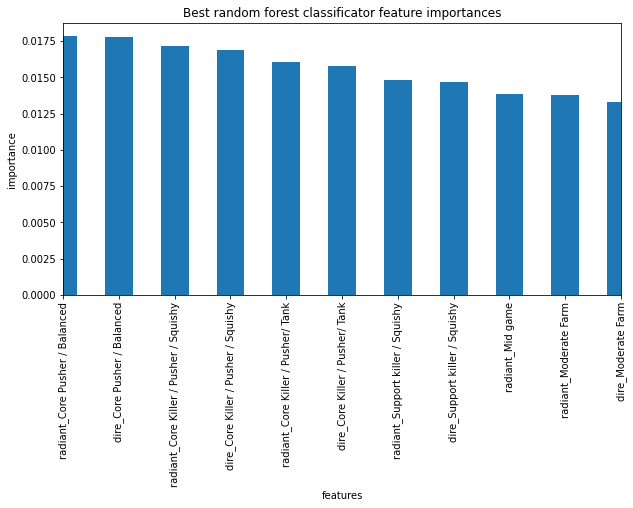

In [49]:
#we plot the first 10 features sorted by relevance
plt.subplots(figsize=(10, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestclassifier.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlim(0,10)
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest classificator feature importances');

#### 4.6.2.2 Data Quantity Assessement

Finally, we need to understand if it will be useful to undertake further data collection. Would more data be useful? We're often led to believe more data is always good, but gathering data invariably has a cost associated with it. Assess this trade off by seeing how performance varies with differing data set sizes. The `learning_curve` function does this conveniently.

In [50]:
fractions = [.2, .25, .3, .35, .4, .45, .5, .6, .75, .8, 1.0]
train_size, train_scores, test_scores = learning_curve(RF_pipe, X_train, y_train, train_sizes=fractions)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

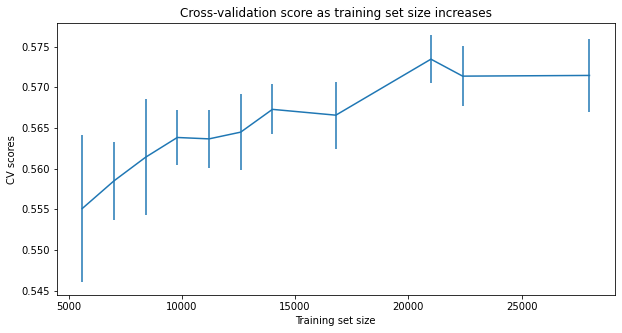

In [51]:
plt.subplots(figsize=(10, 5))
plt.errorbar(train_size, test_scores_mean, yerr=test_scores_std)
plt.xlabel('Training set size')
plt.ylabel('CV scores')
plt.title('Cross-validation score as training set size increases');

#### 4.6.2.3 Summary

The Baseline Case had an accuracy of around 51% of accuracy, our model 1, considering only variables available at the beginning of the game, this is, heroes selected by each team and a count of their categories, increased this accuracy to around 58%.

In relation with the feature importance, the hero functions and categories were all similar in relevance, being hero functions "Core Pusher / Balanced" the variable that the model 1 considered more relevant to predict the winner/loser team.

In relation with the data quantity assessment, we observe that the cross validation score increases with training set sizes of up to 22k matches and then stabilizes, therefore, we can conclude that we have enough data for the model and that more data of the same type will not increase the model's accuracy significantly.



## 4.7 Model 2 - Count of categories + gpm/xpm "in-game" information
### 4.7.1 Initial Model

For this second model as commented before, we will include information about the gpm and xpm gap between teams at minute marks 5, 8, 10, 12 and 15. Also, we will include only information about the hero categories of each team; in particular, a count of how many hero functions, hero farm dependencies and hero powerspikes there are in each team. Information about the specifics heroes selected by each team will be excluded.

In [52]:
#reset the index 
model2 = model2.reset_index()
#check head for format confirmation
model2.head(3)

,match_id,diff_gpm5,diff_xpm5,diff_gpm8,diff_xpm8,diff_gpm10,diff_xpm10,diff_gpm12,diff_xpm12,diff_gpm15,...,dire_Core Pusher / Balanced,dire_Support healer / Tank,dire_Support killer / Squishy,dire_High Farm,dire_Low Farm,dire_Moderate Farm,dire_Early game,dire_Late game,dire_Mid game,radiant_win
0,0,-41.48,-3.60,-6.575,28.250,-8.54,16.82,-18.733333,2.933333,9.426667,...,1,0,1,2,1,2,1,2,2,1
1,1,-32.84,-41.00,-17.025,-18.825,-31.62,-38.28,-36.350000,-53.350000,-2.573333,...,0,0,1,2,1,2,1,2,2,0
2,2,20.88,9.16,-9.575,-22.475,-24.12,-22.28,-18.083333,-20.633333,13.800000,...,4,0,1,0,3,2,3,0,2,0


In [53]:
#split of variables for model2, X for dependendant features, y for independent feature
X = model2.iloc[:,1:-1]
y = model2.iloc[:,-1]

In [54]:
#check head of dependant variables for model2
X.head(3)

,diff_gpm5,diff_xpm5,diff_gpm8,diff_xpm8,diff_gpm10,diff_xpm10,diff_gpm12,diff_xpm12,diff_gpm15,diff_xpm15,...,dire_Core Killer / Tank,dire_Core Pusher / Balanced,dire_Support healer / Tank,dire_Support killer / Squishy,dire_High Farm,dire_Low Farm,dire_Moderate Farm,dire_Early game,dire_Late game,dire_Mid game
0,-41.48,-3.60,-6.575,28.250,-8.54,16.82,-18.733333,2.933333,9.426667,16.506667,...,0,1,0,1,2,1,2,1,2,2
1,-32.84,-41.00,-17.025,-18.825,-31.62,-38.28,-36.350000,-53.350000,-2.573333,-16.320000,...,1,0,0,1,2,1,2,1,2,2
2,20.88,9.16,-9.575,-22.475,-24.12,-22.28,-18.083333,-20.633333,13.800000,19.600000,...,0,4,0,1,0,3,2,3,0,2


In [55]:
#check head of independent features 
y.head(3)

0    1
1    0
2    0
Name: radiant_win, dtype: int32

In [56]:
#split of train and test sets, with 0.3 test set and random state of 47
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, test_size=0.3, 
                                                    random_state=47)

In [57]:
#check of shapes of train and test sets for dependent features
X_train.shape, X_test.shape

((34943, 34), (14976, 34))

In [58]:
#check of shapes of train and test sets for independent feature
y_train.shape, y_test.shape

((34943,), (14976,))

In [59]:
#generation of the pipeline for model2
RF_pipe2 = make_pipeline(
    RandomForestClassifier(random_state=47)
)

In [60]:
#Call `cross_validate` to estimate the pipeline's performance.
#Pass it the random forest pipe object, `X_train` and `y_train`,
#and get it to use 5-fold cross-validation
rf_default_cv_results2 = cross_validate(RF_pipe2, X_train, y_train, cv=5)

In [61]:
rf_cv_scores2 = rf_default_cv_results2['test_score']
rf_cv_scores2

array([0.6958077 , 0.68879668, 0.69079983, 0.70163137, 0.6974814 ])

As it was expected, the model including information about gpm and xpm for each team has a much better performance than the first model. This is logical, as we identified in the EDA that advantages in gpm and xpm in winning teams were observable across all game durations.

The model, without hyperparameter tunning has a performance of around 69%, we will search for best parameters to improve the model and see if we can obtain a better performance.

In [62]:
np.mean(rf_cv_scores2), np.std(rf_cv_scores2)

(0.6949033942699883, 0.00462300117637018)

### 4.7.2 Improved model
#### 4.7.2.1 Hyperparameter search using GridSearchCV

We will improve the model by finding the best number of estimators using GridSearchCV

In [63]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=40)]
grid_params = {
        'randomforestclassifier__n_estimators': n_est
}
grid_params

{'randomforestclassifier__n_estimators': [10,
  11,
  12,
  14,
  16,
  18,
  20,
  22,
  25,
  28,
  32,
  36,
  41,
  46,
  52,
  58,
  66,
  74,
  83,
  94,
  106,
  119,
  134,
  151,
  170,
  191,
  215,
  242,
  272,
  307,
  345,
  388,
  437,
  492,
  554,
  623,
  701,
  789,
  888,
  1000]}

In [64]:
#Call `GridSearchCV` with the random forest pipeline, passing in the above `grid_params`
#dict for parameters to evaluate, 5-fold cross-validation, and all available CPU cores
rf_grid_cv2 = GridSearchCV(RF_pipe2, param_grid=grid_params, cv=5, n_jobs=-1)

In [65]:
#Now call the `GridSearchCV`'s `fit()` method with `X_train` and `y_train` as arguments
#to actually start the grid search
rf_grid_cv2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('randomforestclassifier',
                                        RandomForestClassifier(random_state=47))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__n_estimators': [10, 11, 12,
                                                                  14, 16, 18,
                                                                  20, 22, 25,
                                                                  28, 32, 36,
                                                                  41, 46, 52,
                                                                  58, 66, 74,
                                                                  83, 94, 106,
                                                                  119, 134, 151,
                                                                  170, 191, 215,
                                                                  242, 272, 307, ...]})

In [66]:
#Code task 26#
#Print the best params (`best_params_` attribute) from the grid search
rf_grid_cv2.best_params_

{'randomforestclassifier__n_estimators': 307}

In [67]:
#cross validate based on 'best_estimator_'
rf_best_cv_results2 = cross_validate(rf_grid_cv2.best_estimator_, X_train, y_train, cv=5)
rf_best_scores2 = rf_best_cv_results2['test_score']
rf_best_scores2

array([0.69380455, 0.69451996, 0.69208757, 0.70134516, 0.70077275])

We can observe that the model's performance has improved slightly with the hyperparameter tunning. To around 70% of accuracy.

In [68]:
np.mean(rf_best_scores2), np.std(rf_best_scores2)

(0.6965059985095559, 0.0038049291234300655)

#### 4.7.2.2 Feature Importance analysis

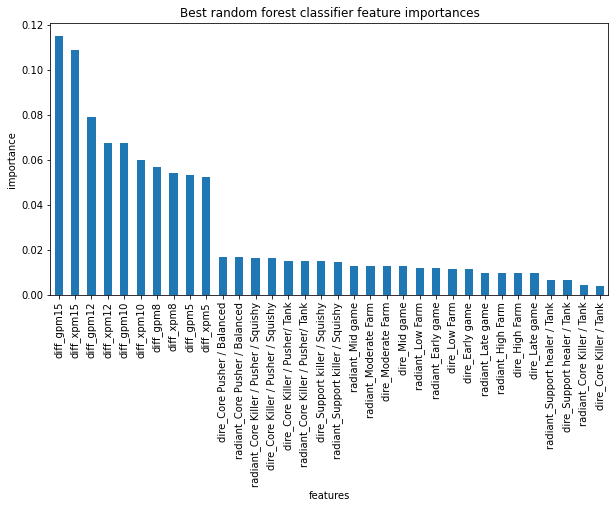

In [69]:
#we plot the feature importance in descending order
plt.subplots(figsize=(10, 5))
imps2 = rf_grid_cv2.best_estimator_.named_steps.randomforestclassifier.feature_importances_
rf_feat_imps2 = pd.Series(imps2, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps2.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest classifier feature importances');

The feature importance analysis shows that when the model has access to "in-game" metrics it finds them much more useful to predict the winner and loser than the static "before-game" information.

Also, it is relevant to comment that the model 2 finds more useful information of minute 15 than information of minute 5. Again, this makes sense to the extent that the more we are into the game, the easier is to predict the winner or loser based on their relative advantage in gpm and xpm.

#### 4.7.2.3 Data Quantity Assessement

Finally, we need to understand if it will be useful to undertake further data collection. Would more data be useful? We're often led to believe more data is always good, but gathering data invariably has a cost associated with it. Assess this trade off by seeing how performance varies with differing data set sizes. The `learning_curve` function does this conveniently.

In [70]:
fractions = [.2, .25, .3, .35, .4, .45, .5, .6, .75, .8, 1.0]
train_size, train_scores, test_scores = learning_curve(RF_pipe2, X_train, y_train, train_sizes=fractions)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

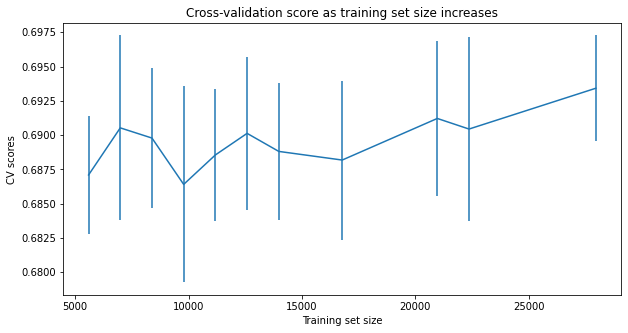

In [71]:
plt.subplots(figsize=(10, 5))
plt.errorbar(train_size, test_scores_mean, yerr=test_scores_std)
plt.xlabel('Training set size')
plt.ylabel('CV scores')
plt.title('Cross-validation score as training set size increases');

We can observe that the improvement in performance for the cross validation scores does not grow until set sizes of around 22k matches in the training set, and then very slightly after that. It is hard to say if more data will increase the cross validation scores.

#### 4.7.2.4 Summary

The baseline case had an accuracy of around 51 % predicting the winning team. Model 1, including information about heroes selected by each team and a count of their heroe's categories, incrased the accuracy to around 58%.

Model 2 excluded information regarding the specific heroes selected by each team and included both a count of heroe's categories for each team and "in-game" information regarding gpm and xpm gap on minutes 5, 8, 10, 12 and 15.

Model 2's accuracy increased signficantly to around 70%.

In relation with feature relevance, Model 2 showed that gpm and xpm information is much more relevant to predict winning team's than any other "pre-game" feature included. This is something that we anticipated in the EDA, as the winning teams had in the majority of cases, regardless of game duration, an advantage in gpm and xpm.



## 4.8 Save of Models

In [72]:
#save Model 1
best_model1 = rf_grid_cv.best_estimator_
best_model1.version = '1.0'
best_model1.pandas_version = pd.__version__
best_model1.numpy_version = np.__version__
best_model1.sklearn_version = sklearn_version
best_model1.X_columns = [col for col in X_train.columns]
best_model1.build_datetime = datetime.datetime.now()
    
modelpath = 'models'
if not os.path.exists(modelpath):
    os.mkdir(modelpath)
Dota2_model1 = os.path.join(modelpath, 'Dota2_Model1.pkl')
if not os.path.exists(Dota2_model1):
    with open(Dota2_model1, 'wb') as f:
        pickle.dump(best_model1, f)

In [73]:
#save model 2
best_model2 = rf_grid_cv2.best_estimator_
best_model2.version = '1.0'
best_model2.pandas_version = pd.__version__
best_model2.numpy_version = np.__version__
best_model2.sklearn_version = sklearn_version
best_model2.X_columns = [col for col in X_train.columns]
best_model2.build_datetime = datetime.datetime.now()
    
modelpath = 'models'
if not os.path.exists(modelpath):
    os.mkdir(modelpath)
Dota2_model2 = os.path.join(modelpath, 'Dota2_model2.pkl')
if not os.path.exists(Dota2_model2):
    with open(Dota2_model2, 'wb') as f:
        pickle.dump(best_model2, f)

## 4.9 Summary and Conclussions - Pre-processing

In this step of the analysis, we generated two different models aiming at predicting which team would win the game on different moments of the game.

The first model (model1), aimed at predicting the winner at minute 0 of the game, by using only information available at the beginning of the game. The second model (model 2) aimed at predicting the winner before minute 15 of the game, and included information of the games until minute 15 (gpm and xpm gap between teams at minutes 5, 8, 10, 12 and 15).

As **baseline case**, to have a reference of how our models were better than random chance, we calculated the proportion of won/lost matches, and concluded that an individual always predicting radiant team as winner, would be right **51% of cases**.

* **Model 1 improved** this prediction **to around 58% of cases**; and
* **Model 2 further improved** this prediction **to around 70% of cases**.

In relation with the pre-processing stage, we conclude that we have generated and saved 2 models, which can be later on used to predict the winner based on the draft 

## 4.10 Next Steps - Deployment + Improvements

In relation with the deployment of the model, we are working on a way to make both models accessible to users through a web interface, so that they can use the models to make predictions based on teams heroes picked as well as information regarding gpm and xpm before minute 15 of the game.

Our idea is to work on an platform in which users will be able to both visualize team's compositions based on heroe's functions, farm dependencies and powerspikes, as well as to predict what team will win or lose.

In relation with this project, there are many questions that have arised in the Exploratory Data Analysis Stage that are still unanswered and we would like to explore them furthermore in the future, such as:

* prediction of game duration;
* prediction of skill level of individual players;
* prediction of gpm and xpm at certain minutes;
* prediction of what items will be more effective;
* development of intelligence regarding best and worst heroe picks;
* etc.

In order to prioritize future developments, we will work with pro-players and Dota2 streamers to consider their input as well as their suscribers' feedback to prioritize developments.